In [ ]:
!pip install geopandas folium osmnx pyproj shapely --quiet


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium


stations = gpd.read_file("/content/station_point.shp")
city = gpd.read_file("/content/kk.shp")

print(stations.head())
print(city.head())


print("Stations CRS:", stations.crs)
print("City CRS:", city.crs)


   OBJECTID_1                                   NAME_T  \
0          33       สถานีขนส่งผู้โดยสาร อ.พล จ.ขอนแก่น   
1         101  สถานีขนส่งผู้โดยสาร อ.บ้านไผ่ จ.ขอนแก่น   
2          34  สถานีขนส่งผู้โดยสาร จ.ขอนแก่น แห่งที่ 3   
3           2  สถานีขนส่งผู้โดยสารรถปรับอากาศจ.ขอนแก่น   
4          86            สถานีขนส่งผู้โดยสาร จ.ขอนแก่น   

                                      NAME_E  \
0  BUS TERMINAL THETSABAN MUEANG MUEANG PHON   
1               AMPHOE BAN PHAI BUS TERMINAL   
2                   KHON KAEN BUS TERMINAL 3   
3     KHON KAEN AIR-CONDITIONED BUS TERMINAL   
4                     KHON KAEN BUS TERMINAL   

                                LOCATION_T               OWNER   ProvName  \
0                               ซอยขนส่ง 7  เทศบาลเมืองเมืองพล  KHON KAEN   
1                       ถนนจันทร์ประสิทธิ์         อบจ.ขอนแก่น  KHON KAEN   
2  ทางหลวงแผ่นดินหมายเลข 230 (เลี่ยงเมือง)         อบจ.ขอนแก่น  KHON KAEN   
3                             ถนนกลางเมือง    เทศบาลนค

In [ ]:
stations = stations.to_crs(epsg=32647)
city = city.to_crs(epsg=32647)


In [ ]:
stations_kk["buffer"] = stations_kk.buffer(5000)
buffer_gdf = stations_kk.set_geometry("buffer")


In [ ]:
buffer_gdf = gpd.GeoDataFrame(
    stations.drop(columns="geometry"),
    geometry=stations.geometry.buffer(5000),
    crs=stations.crs
)



In [ ]:
join = gpd.sjoin(stations, city, how="left", predicate="within")

count_station = join.groupby("AMP_NAME_E").size().reset_index(name="station_count")

print(count_station)


         AMP_NAME_E  station_count
0          Ban Phai              1
1         Chum Phae              1
2           Kranuan              1
3  Mueang Khon Kaen              3
4              Phon              1
5         Phu Wiang              1


In [ ]:
intersect = gpd.overlay(city, buffer_gdf, how="intersection")


intersect["area_km2"] = intersect.area / 1e6

impact_area = intersect.groupby("AMP_NAME_E")["area_km2"].sum().reset_index()

print(impact_area)


         AMP_NAME_E    area_km2
0          Ban Phai   78.413712
1         Chum Phae   78.413712
2           Kranuan   78.413712
3  Mueang Khon Kaen  235.241137
4              Phon   78.413712
5         Phu Wiang   78.413712


In [ ]:
#fig, ax = plt.subplots(figsize=(8,8))

#city.plot(ax=ax, facecolor="none", edgecolor="black")
#buffer_gdf.plot(ax=ax, alpha=0.4)
#stations.plot(ax=ax, color="red", markersize=10)

#plt.title("station Area Buffer 5 km")
#plt.show()


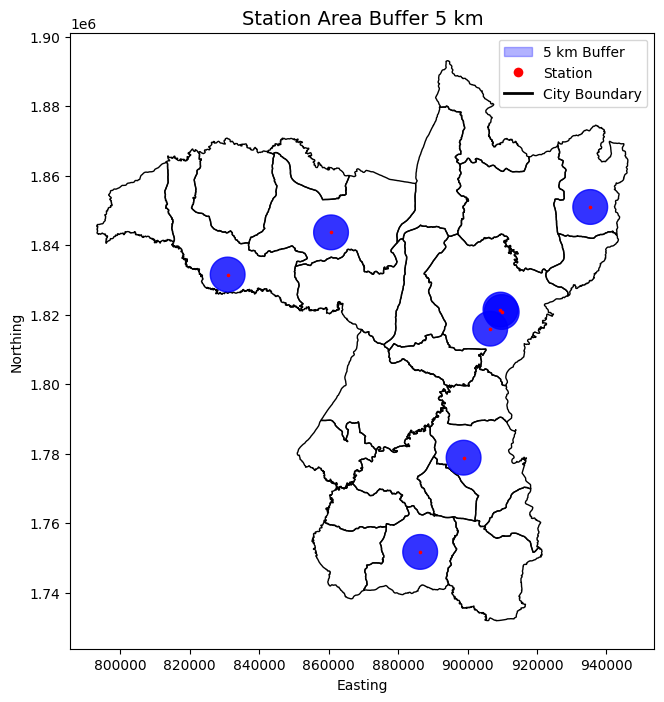

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8,8))


city.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=1
)


buffer_gdf.plot(
    ax=ax,
    facecolor="blue",
    edgecolor="blue",
    alpha=0.8
)


stations.plot(
    ax=ax,
    color="red",
    markersize=2.5
)

plt.title("Station Area Buffer 5 km", fontsize=14)


legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='5 km Buffer'),
    Line2D([0], [0], marker='o', color='w', label='Station',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], color='black', lw=2, label='City Boundary')
]

ax.legend(handles=legend_elements, loc='upper right')

plt.xlabel("Easting")
plt.ylabel("Northing")

plt.show()


In [ ]:
stations_wgs = stations.to_crs(epsg=4326)
buffer_wgs = buffer_gdf.to_crs(epsg=4326)
city_wgs = city.to_crs(epsg=4326)


In [ ]:
center = stations_wgs.geometry.union_all().centroid

m = folium.Map(
    location=[center.y, center.x],
    zoom_start=11,
    tiles="CartoDB positron"
)


In [ ]:
layer_city = folium.FeatureGroup(name="City Boundary")
layer_buffer = folium.FeatureGroup(name="Service Area (5 km)")
layer_station = folium.FeatureGroup(name="Stations")


In [ ]:
for geom in city_wgs.geometry:
    polys = [geom] if geom.geom_type == "Polygon" else geom.geoms
    for poly in polys:
        folium.Polygon(
            locations=[(y, x) for x, y in poly.exterior.coords],
            color="black",
            weight=2,
            fill=False
        ).add_to(layer_city)


In [ ]:
for geom in buffer_wgs.geometry:
    polys = [geom] if geom.geom_type == "Polygon" else geom.geoms
    for poly in polys:
        folium.Polygon(
            locations=[(y, x) for x, y in poly.exterior.coords],
            color="green",
            weight=1,
            fill=True,
            fill_color="green",
            fill_opacity=0.25
        ).add_to(layer_buffer)


In [ ]:
#for i, pt in enumerate(stations_wgs.geometry):
   #folium.CircleMarker(
       # location=[pt.y, pt.x],
       # radius=5,
       # color="red",
       # fill=True,

        #fill_opacity=0.9,
       # popup=f"Station {i+1}"
   # ).add_to(layer_station)



In [ ]:
for idx, row in stations_wgs.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="red", icon="bus", prefix="fa")
    ).add_to(m)


In [ ]:

layer_city.add_to(m)
layer_buffer.add_to(m)
layer_station.add_to(m)

folium.LayerControl().add_to(m)


In [ ]:
legend_html = """
<div style="
position: fixed;
bottom: 40px;
left: 40px;
width: 180px;
background: white;
border:2px solid grey;
z-index:9999;
padding:10px;
font-size:14px;
">
<b>Legend</b><br>
<span style="color:black;">▬</span> City Boundary<br>
<span style="color:green;">●</span> Service Area (5 km)<br>
<i class="fa fa-bus" style="color:red"></i> Station
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))
m

1. อธิบายความแตกต่างระหว่าง Spatial Join และ Attribute Join
---
คำตอบ  Spatial Join และ Attribute Join แตกต่างกันที่ เกณฑ์การเชื่อมโยง และประเภทข้อมูลที่ใช้ Spatial Join รวมข้อมูลโดยใช้ตำแหน่งที่ตั้งทางภูมิศาสตร์ ใช้ข้อมูล vector ที่มีตำแหน่ง แต่ Attribute Join จะใช้รหัสหรือฟิลด์ข้อมูลที่เหมือนกัน ในตาราง (Attribute Table) ไม่จำเป็นต้องมีตำแหน่งที่ตั้ง

2. ทำไมเราต้องแปลงระบบพิกัดก่อนใช้ buffer() ใน GeoPandas?


---

คำตอบ เพราะ buffer ใช้หน่วยของระบบพิกัด
ถ้าใช้ WGS84 ที่เป็นหน่วย องศา จะทำให้ระยะผิดพลาด บัฟเฟอร์จะมีรูปร่างผิดเพี้ยนและขนาดไม่เท่ากันในแต่ละพื้นที่
ต้องใช้ CRS ที่เป็นเมตร เช่น UTM จะให้ค่าระยะทางเป็นหน่วยระยะทางจริง

3. หากต้องการวิเคราะห์พื้นที่ให้บริการของสถานีขนส่งในระยะ 10 กิโลเมตร แทน 5 กิโลเมตร ต้องแก้ไขส่วนใดของโค้ด?


---



buffer_gdf = gpd.GeoDataFrame(
    stations.drop(columns="geometry"),
    geometry=stations.geometry.buffer(5000),
    crs=stations.crs
)

เปลี่ยนจาก 5000 เป็น 10000 (เมตร) เช่น

In [ ]:
buffer_gdf = gpd.GeoDataFrame(
    stations.drop(columns="geometry"),
    geometry=stations.geometry.buffer(10000),
    crs=stations.crs
)



4. วิธีใดที่เหมาะสมที่สุดในการแสดงผลข้อมูลเชิงพื้นที่ในรูปแบบ Interactive Map? เพราะเหตุใด?


---

คำตอบ Folium เพราะสามารถ zoom, เปิด-ปิด layer ได้ และใช้งานบนเว็บได้ง่าย

5. หากพบว่า Buffer ที่สร้างมีขนาดไม่ถูกต้อง อาจเกิดจากสาเหตุใดได้บ้าง? และสามารถแก้ไขได้อย่างไร?


---
สาเหตุ:

ไม่ได้แปลง CRS หน่วยองศา เป็นระบบพิกัด หน่วยเมตร

geometry มีปัญหา

วิธีแก้:

ตรวจสอบ .crs
แปลง CRS องศา เป็นระบบพิกัด หน่วยเมตร


แหล่งข้อมูล SHp


---


ข้อมูล สถานีขนส่งผู้โดยสาร:
 MOT Data Catalog. (2026). สถานีขนส่งผู้โดยสาร [bus-terminal-pass]. กระทรวงคมนาคม, ศูนย์เทคโนโลยีสารสนเทศและการสื่อสาร. https://datagov.mot.go.th/dataset/bus-terminal-pass

ข้อมูล ขอบเขตจังหวัดขอนแก่น:
csuwan.weebly.com. (n.d.). E-PORTAL — ดาวน์โหลดข้อมูล GIS [เว็บเพจ]. Weebly.https://csuwan.weebly.com/360436343623360936603650362736213604--download.html

6606614664 เจนจิรา เคหะฐาน